In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import warnings

In [2]:
train = pd.read_csv('../data/train.csv',header=0)
test = pd.read_csv('../data/test.csv',header=0)

/var/folders/2r/vz71dl552fd4t6lk1z7s6_bh0000gn/T/ipykernel_94205/1621859618.py:1: DtypeWarning: Columns (435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv('../data/train.csv',header=0)


## Translate Time as a cyclic feature

In [3]:
# Transform the time in minutes starting a midnight
train['time'] = pd.to_datetime(train['time'], format='%H:%M:%S')
test['time'] = pd.to_datetime(test['time'], format='%H:%M:%S')

train['hour'] = train.time.apply(lambda x : x.hour)
test['hour'] = test.time.apply(lambda x : x.hour)

train['time_min'] = train['time'].dt.hour * 60 + train['time'].dt.minute
test['time_min'] = test['time'].dt.hour * 60 + test['time'].dt.minute


In [4]:
def actual_time(df, col_var):
    df[['hours', 'minutes']] = df[col_var].str.extract('(-?\d+):(\d+)')
    df['time_diff'] = df['hours'].astype(int) * 60 - df['minutes'].astype(int)
    
    # Calculate actual time in minutes for each bg measurement
    df['actual_time'] = df['time_min'] + df['time_diff']
    
    df = df.drop(columns=['hours', 'minutes', 'time_diff'])
    
    return df

<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
/var/folders/2r/vz71dl552fd4t6lk1z7s6_bh0000gn/T/ipykernel_94205/986835876.py:2: SyntaxWarning: invalid escape sequence '\d'
  df[['hours', 'minutes']] = df[col_var].str.extract('(-?\d+):(\d+)')


In [ ]:
def create_cyclic_time_features(times, hours, step):
    """Generate cosinus and sinus translation of time in minutes.

    From time in minutes, generates sinus and cosinus translation.
    Tranlate a 0 to 1440 minute of the day into two linked and cylic values.

    Args:
        times (Series): Times to translate in features
        hours (list of str): Names for each step of the time sequence
        step (int): Step in minute between each hours
    Return:
        time_feature (pd.DataFrame): Dataframe with n rows for n times and 2 * m
        for m translation of the timesteps with cosinus and sinus.
    """
    cos_col = ["tcos-" + hour for hour in hours]
    sin_col = ["tsin-" + hour for hour in hours]
    # Dataframe to store the sequential sinus and cosinus
    time_features = pd.DataFrame(columns=cos_col+sin_col)

    # Get the time window length
    time_window = len(hours) * step - step
    
    for count, time in enumerate(times):
        # Generate every time steps
        timesteps = np.arange(int(time)-time_window, int(time) + step, step)
        # Consider negative value of time as pm
        timesteps = np.where(timesteps < 0, timesteps + 1440, timesteps)
        
        tcos = np.cos(2 * np.pi * timesteps / 1440)
        tsin = np.sin(2 * np.pi * timesteps / 1440)

        time_features.loc[count] = np.concatenate([tcos, tsin])
    
    return time_features

In [ ]:
hours = [col.replace("bg-","") for col in train.columns if "bg-" in col]

In [ ]:
time_feature = create_cyclic_time_features(train.loc[0:100]["time_min"], hours, 5)

# NA treatment

## Blood glucose

In [5]:
bg_columns = [col for col in train.columns if col.startswith('bg-')]
bg_df = pd.melt(train, id_vars=['id', 'time_min'], value_vars=bg_columns, var_name='bg_time', value_name='bg_value')
bg_df = actual_time(bg_df, 'bg_time')

bg_df.head()

,id,time_min,bg_time,bg_value,actual_time
0,p01_0,370,bg-5:55,NaN,15
1,p01_1,385,bg-5:55,NaN,30
2,p01_2,400,bg-5:55,NaN,45
3,p01_3,415,bg-5:55,NaN,60
4,p01_4,430,bg-5:55,NaN,75


In [6]:
def fill_na_values(group):
    # For the remaining NA values, use the mean of adjacent non-NA values
    group['bg_value'] = group['bg_value'].interpolate(method='linear')
    
    # # Backward fill the first NA values
    group['bg_value'] = group['bg_value'].bfill()
    # Forward fill the last NA values
    group['bg_value'] = group['bg_value'].ffill()
    
    return group


Number of NaN values: 1371684


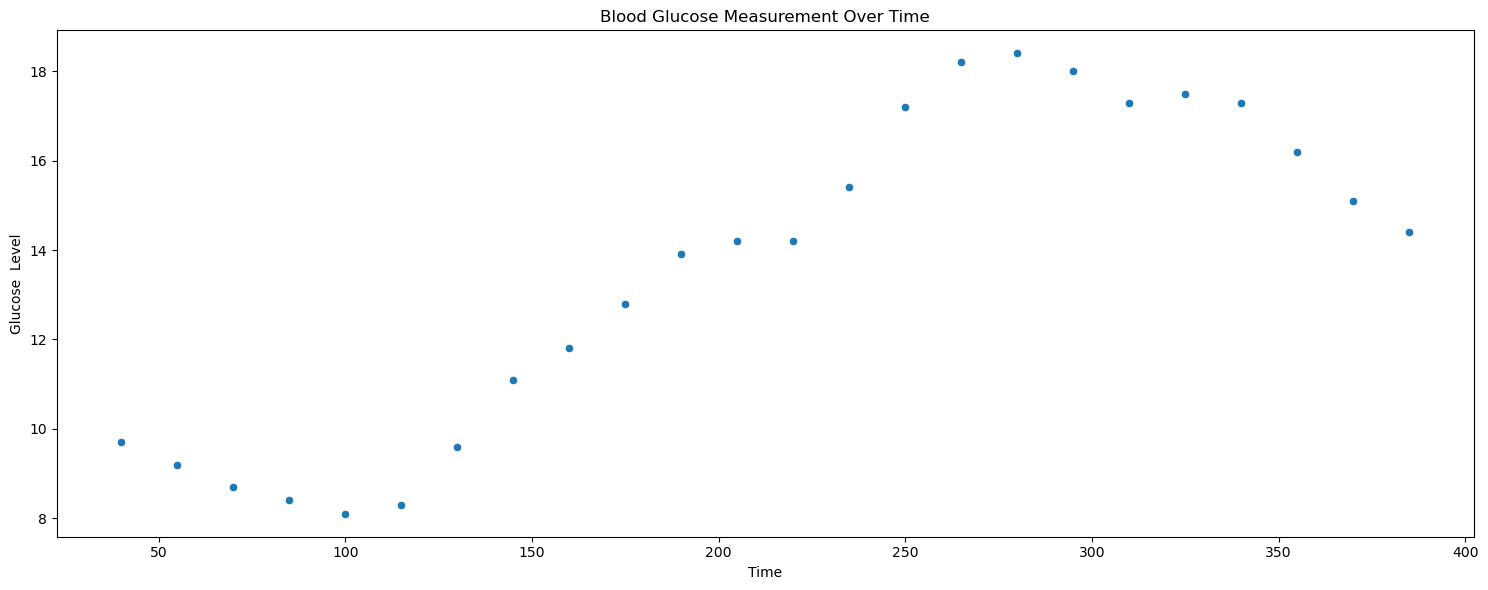


Number of remaining NaN values: 0


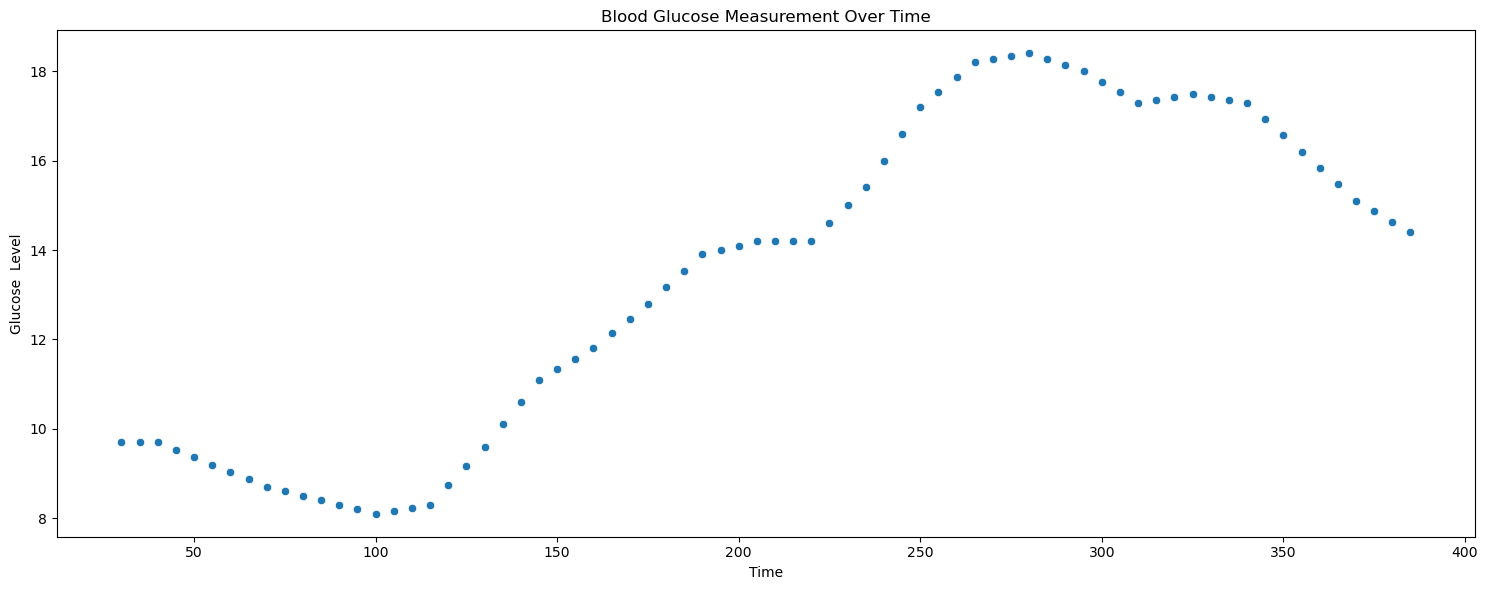

In [7]:
# Print the number of NaN values before transformation
nan_count = bg_df['bg_value'].isna().sum()
print(f"\nNumber of NaN values: {nan_count}")

# Plot an example sample of blood glucose measurements before NA transformation
plt.figure(figsize=(15, 6))
sns.scatterplot(x='actual_time', y='bg_value', data=bg_df[bg_df["id"] == "p01_1"])   
plt.title('Blood Glucose Measurement Over Time')
plt.xlabel('Time')
plt.ylabel('Glucose  Level')
plt.tight_layout() 
plt.show()

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    bg_df = bg_df.groupby('id').apply(fill_na_values).reset_index(drop=True)

# Check if there are any remaining NaN values
nan_count = bg_df['bg_value'].isna().sum()
print(f"\nNumber of remaining NaN values: {nan_count}")

# Plot an example sample of blood glucose measurements after NA transformation
plt.figure(figsize=(15, 6))
sns.scatterplot(x='actual_time', y='bg_value', data=bg_df[bg_df["id"] == "p01_1"])   
plt.title('Blood Glucose Measurement Over Time')
plt.xlabel('Time')
plt.ylabel('Glucose  Level')
plt.tight_layout() 
plt.show()

## Insulin

In [20]:
ins_columns = [col for col in train.columns if col.startswith('insulin')]
ins_df = pd.melt(train, id_vars=['id', 'time_min'], value_vars=ins_columns, var_name='ins_time', value_name='ins_value')
ins_df = actual_time(ins_df, 'ins_time')

In [22]:
nan_counts = ins_df.groupby('id').agg({
    'ins_value': [('total', 'count'), ('nan_count', lambda x: x.isna().sum())]
}).reset_index()

nan_counts.columns = ['id', 'total_count', 'nan_count']

nan_counts = nan_counts[nan_counts['nan_count'] > 0].sort_values('nan_count', ascending=False)

print(nan_counts)


               id  total_count  nan_count
127170      p11_0            0         72
147953   p11_6603            0         72
147937    p11_659            0         72
147938   p11_6590            0         72
147939   p11_6591            0         72
...           ...          ...        ...
143262  p11_24480           70          2
143176  p11_24402           70          2
151099   p11_9435           71          1
143263  p11_24481           71          1
143175  p11_24401           71          1

[9517 rows x 3 columns]


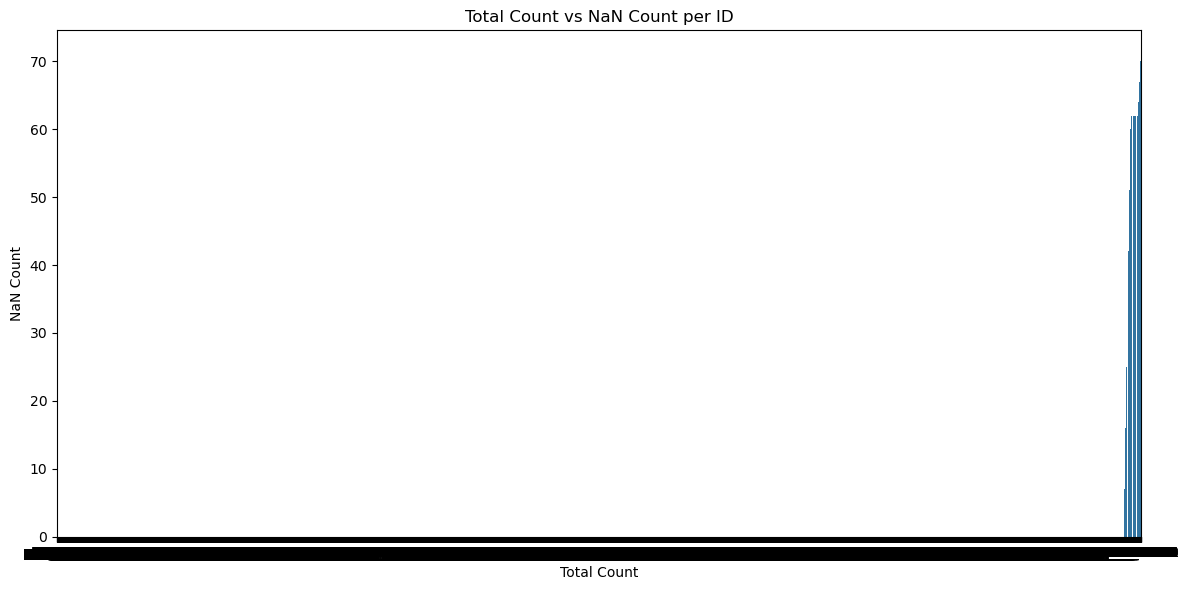

In [23]:
# plt.figure(figsize=(12, 6))
# sns.barplot(data=nan_counts, x='id', y='total_count')
# plt.title('Total Count vs NaN Count per ID')
# plt.xlabel('Total Count')
# plt.ylabel('NaN Count')
# plt.tight_layout()
# plt.show()

In [10]:
def fill_na_values(group):
    group['ins_value'] = group['ins_value'].fillna(group['ins_value'].quantile(0.25))
    
    return group


Number of NaN values: 677556


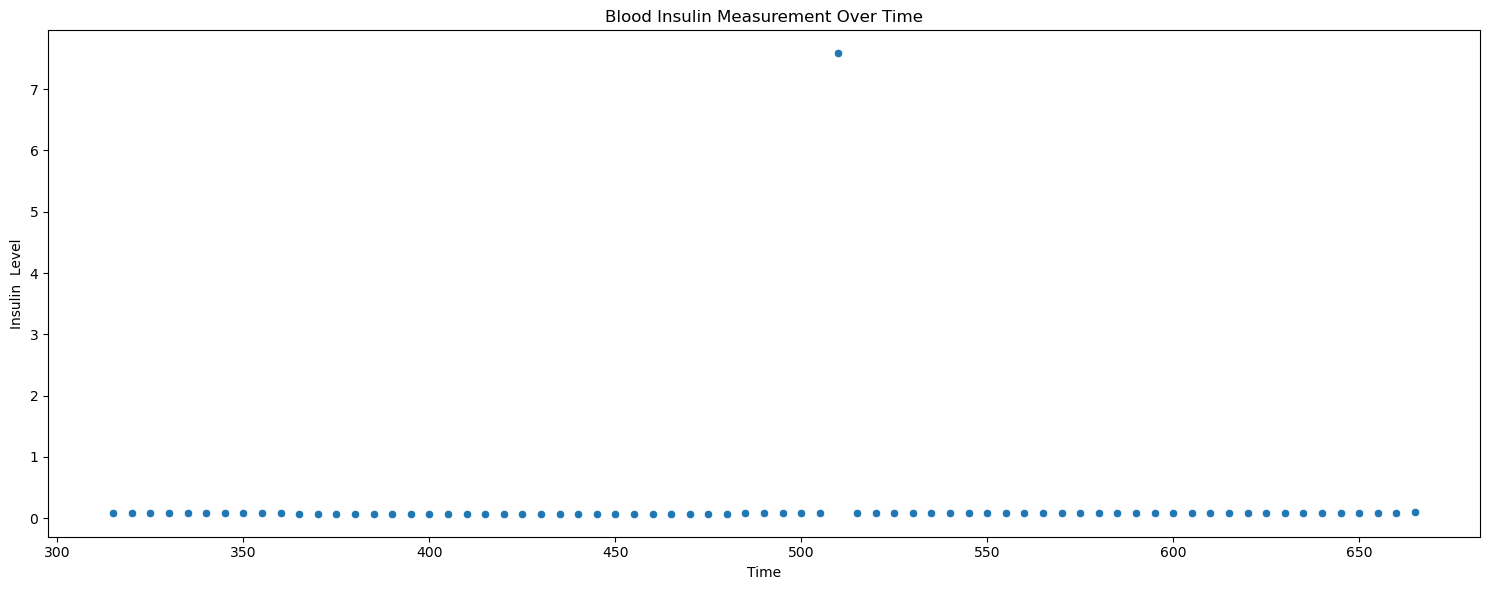


Number of remaining NaN values: 0


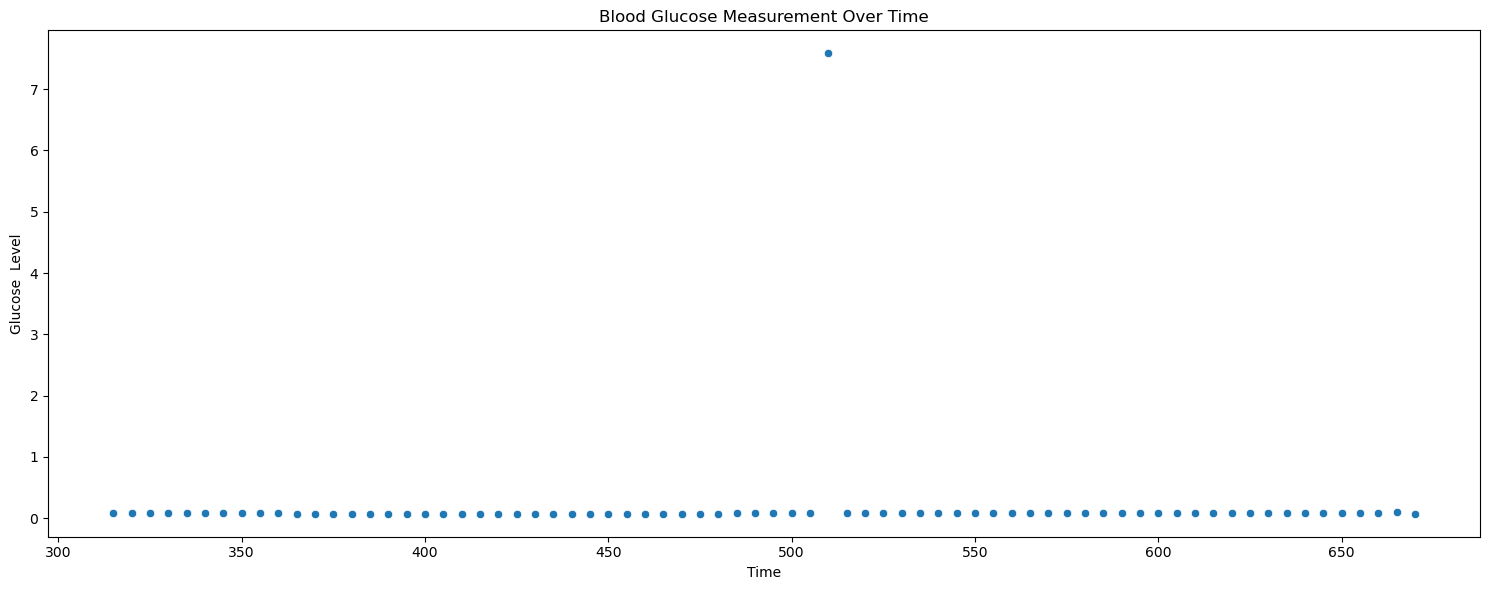

In [11]:
# Print the number of NaN values before transformation
nan_count = ins_df['ins_value'].isna().sum()
print(f"\nNumber of NaN values: {nan_count}")

# Plot an example sample of blood glucose measurements before NA transformation
plt.figure(figsize=(15, 6))
sns.scatterplot(x='actual_time', y='ins_value', data=ins_df[ins_df["id"] == "p11_24401"])   
plt.title('Blood Insulin Measurement Over Time')
plt.xlabel('Time')
plt.ylabel('Insulin  Level')
plt.tight_layout() 
plt.show()

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    ins_df = ins_df.groupby('id').apply(fill_na_values).reset_index(drop=True)
    ins_df['ins_value'] = ins_df['ins_value'].fillna(ins_df['ins_value'].quantile(0.25))

# Check if there are any remaining NaN values
nan_count = ins_df['ins_value'].isna().sum()
print(f"\nNumber of remaining NaN values: {nan_count}")

# Plot an example sample of blood glucose measurements after NA transformation
plt.figure(figsize=(15, 6))
sns.scatterplot(x='actual_time', y='ins_value', data=ins_df[ins_df["id"] == "p11_24401"])   
plt.title('Blood Glucose Measurement Over Time')
plt.xlabel('Time')
plt.ylabel('Glucose  Level')
plt.tight_layout() 
plt.show()

## Carbs

In [12]:
carbs_columns = [col for col in train.columns if col.startswith('carbs')]
carbs_df = pd.melt(train, id_vars=['id', 'time_min'], value_vars=carbs_columns, var_name='carbs_time', value_name='carbs_value')
carbs_df = actual_time(carbs_df, 'carbs_time')


Number of NaN values: 12561854


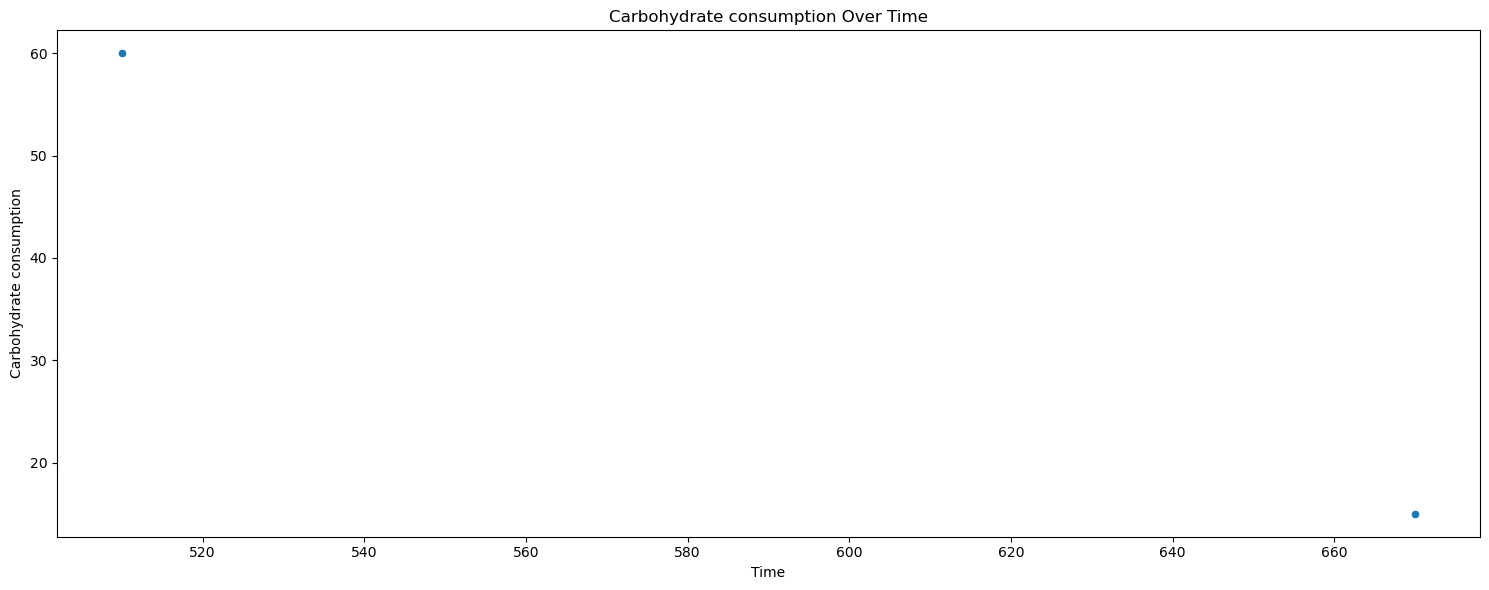


Number of remaining NaN values: 0


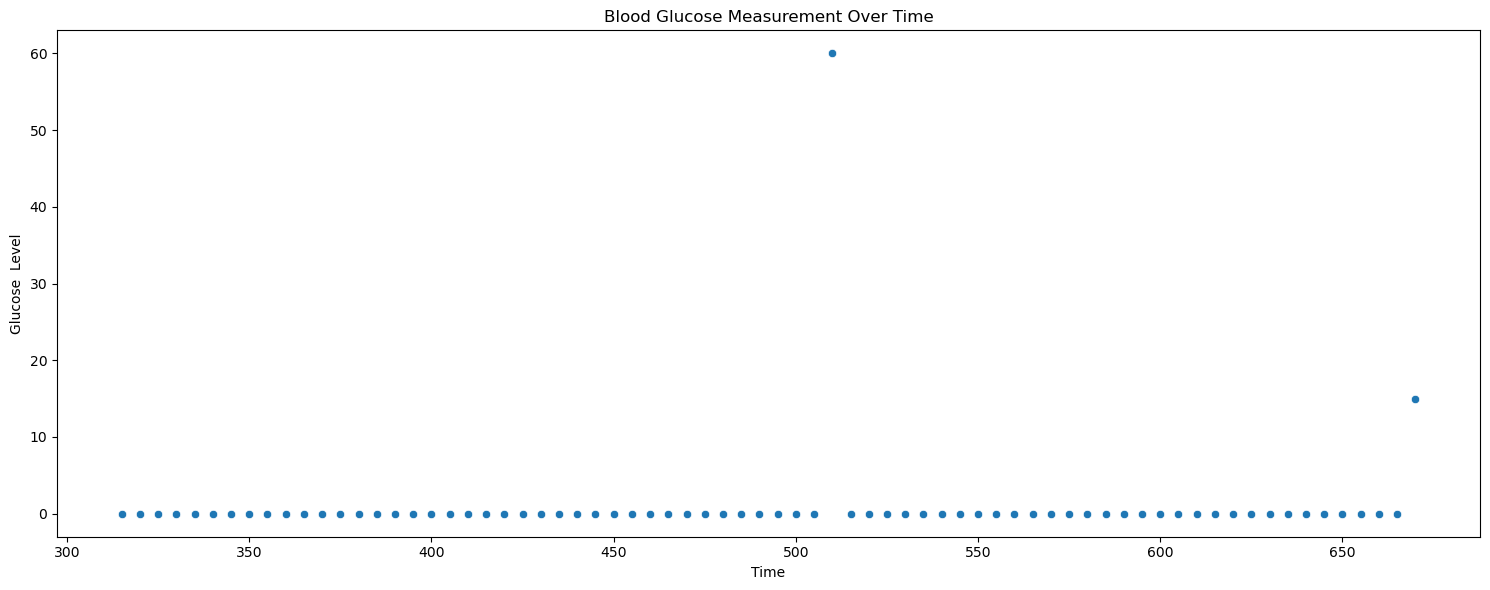

In [13]:
# Print the number of NaN values before transformation
nan_count = carbs_df['carbs_value'].isna().sum()
print(f"\nNumber of NaN values: {nan_count}")

# Plot an example sample of blood glucose measurements before NA transformation
plt.figure(figsize=(15, 6))
sns.scatterplot(x='actual_time', y='carbs_value', data=carbs_df[carbs_df["id"] == "p11_24401"])   
plt.title('Carbohydrate consumption Over Time')
plt.xlabel('Time')
plt.ylabel('Carbohydrate consumption')
plt.tight_layout() 
plt.show()

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    carbs_df['carbs_value'] = carbs_df['carbs_value'].fillna(0)

# Check if there are any remaining NaN values
nan_count = carbs_df['carbs_value'].isna().sum()
print(f"\nNumber of remaining NaN values: {nan_count}")

# Plot an example sample of blood glucose measurements after NA transformation
plt.figure(figsize=(15, 6))
sns.scatterplot(x='actual_time', y='carbs_value', data=carbs_df[carbs_df["id"] == "p11_24401"])   
plt.title('Blood Glucose Measurement Over Time')
plt.xlabel('Time')
plt.ylabel('Glucose  Level')
plt.tight_layout() 
plt.show()

## Calories

In [14]:
cals_columns = [col for col in train.columns if col.startswith('cals')]
cals_df = pd.melt(train, id_vars=['id', 'time_min'], value_vars=cals_columns, var_name='cals_time', value_name='cals_value')
cals_df = actual_time(cals_df, 'cals_time')

## Heart rate

In [15]:
hr_columns = [col for col in train.columns if col.startswith('hr')]
hr_df = pd.melt(train, id_vars=['id', 'time_min'], value_vars=hr_columns, var_name='hr_time', value_name='hr_value')
hr_df = actual_time(hr_df, 'hr_time')